# Federated Variational Autoencoders in biomedical data
Here, an example of a variability analysis using a Multi-channel variational autoencoder proposed by [Antelmi _et_ al](http://proceedings.mlr.press/v97/antelmi19a.html).

In [1]:
import copy
import pandas as pd

import torch
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import datasets, transforms

In [2]:
N_CENTERS = 4
N_ROUNDS = 50   # Number of iterations between all the centers training and the aggregation process.

N_EPOCHS = 100   # Number of epochs before aggregating
BATCH_SIZE = 48
LR = 1e-2       # Learning rate

We define a set of functions to distribute our dataset across multiple centers (`split_iid`) and for doing federated averaging (`federated_averaging`).

In [3]:
import numpy as np
def split_iid(df, n_centers):
    """ Split pandas DataFrame dataset randomly into n_centers """
    data = df.sample(frac=1)  # Shuffle dataset
    data =  np.array_split(data, n_centers)
    return data

In [4]:
def federated_averaging(models, n_obs_per_client):
    assert len(models) > 0, 'An empty list of models was passed.'
    assert len(n_obs_per_client) == len(models), 'List with number of observations must have ' \
                                                 'the same number of elements that list of models.'

    # Compute proportions
    n_obs = sum(n_obs_per_client)
    proportions = [n_k / n_obs for n_k in n_obs_per_client]

    # Empty model parameter dictionary
    avg_params = models[0].state_dict()
    for key, val in avg_params.items():
        avg_params[key] = torch.zeros_like(val)

    # Compute average
    for model, proportion in zip(models, proportions):
        for key in avg_params.keys():
            avg_params[key] += proportion * model.state_dict()[key]

    # Copy one of the models and load trained params
    avg_model = copy.deepcopy(models[0])
    avg_model.load_state_dict(avg_params)

    return avg_model

## Federating dataset

In [5]:
csv = 'https://gitlab.inria.fr/ssilvari/flhd/-/raw/master/heterogeneous_data/pseudo_adni.csv?inline=false'
df = pd.read_csv(csv)

df.sample()

,SEX,AGE,PTEDUCAT,CDRSB.bl,ADAS11.bl,MMSE.bl,RAVLT.immediate.bl,RAVLT.learning.bl,RAVLT.forgetting.bl,FAQ.bl,WholeBrain.bl,Ventricles.bl,Hippocampus.bl,MidTemp.bl,Entorhinal.bl,APOE4,ABETA.MEDIAN.bl,PTAU.MEDIAN.bl,TAU.MEDIAN.bl
669,1.0,69.0,14.945415,0,7,27.0,28.482003,3.0,3.349521,0,0.687166,0.007506,0.005003,0.013367,0.002208,0,200.999667,9.887908,7.109941


In [6]:
df.columns

Index(['SEX', 'AGE', 'PTEDUCAT', 'CDRSB.bl', 'ADAS11.bl', 'MMSE.bl',
       'RAVLT.immediate.bl', 'RAVLT.learning.bl', 'RAVLT.forgetting.bl',
       'FAQ.bl', 'WholeBrain.bl', 'Ventricles.bl', 'Hippocampus.bl',
       'MidTemp.bl', 'Entorhinal.bl', 'APOE4', 'ABETA.MEDIAN.bl',
       'PTAU.MEDIAN.bl', 'TAU.MEDIAN.bl'],
      dtype='object')

In [7]:
df["RAVLT.learning.bl"].value_counts()

4.0     153
5.0     128
3.0     117
6.0     112
0.0     100
2.0      98
1.0      96
7.0      90
8.0      62
9.0      31
10.0     10
12.0      2
11.0      1
Name: RAVLT.learning.bl, dtype: int64

Now, `federated_dataset` is a list of subsets of the main dataset.

In [8]:
federated_dataset = split_iid(df, n_centers=N_CENTERS)
print('Number of centers:', len(federated_dataset))

Number of centers: 4


Finally, we must parse each dataframe in the form of a tensor Dataset grouping variables in 5 channels:
* Volumetric data
* Demographics
* Cognition
* Genetics: Apolipoprotein E (APOE)
* Fluid biomarkers: Amyloid beta (Abeta) and Tau concentrations in the Cerebrospinal fluid (CSF).

In [9]:
def get_channels():
    
    channel_1 = ['WholeBrain.bl', 'Ventricles.bl', 'Hippocampus.bl', 'MidTemp.bl', 'Entorhinal.bl']
    channel_2 = ['SEX', 'AGE', 'PTEDUCAT']
    channel_3 = ['CDRSB.bl', 'ADAS11.bl', 'MMSE.bl', 'RAVLT.immediate.bl', 'RAVLT.learning.bl', 'RAVLT.forgetting.bl', 'FAQ.bl']
    channel_4 = ['APOE4']
    channel_5 = ['ABETA.MEDIAN.bl', 'PTAU.MEDIAN.bl', 'TAU.MEDIAN.bl']
    return channel_1, channel_2, channel_3, channel_4, channel_5

def get_data_as_multichannel_tensor_dataset(df):
    """Takes a dataframe, splits it into multiple channels and parse each channel as a tensor"""
    channel_1, channel_2, channel_3, channel_4, channel_5 = get_channels()
    
    df = (df - df.mean())/df.std()
    def as_tensor(cols):
        return torch.tensor(df[cols].values).float()
    
    return [as_tensor(channel_1), as_tensor(channel_2), as_tensor(channel_3), as_tensor(channel_4), as_tensor(channel_5)]

## Defining and distributing a model: Variational Autoencoder
In this excercise we will use the Multi-channel Variational Autoencoder proposed by Antelmi _et_ al.

In [10]:
!pip install -q git+https://gitlab.inria.fr/epione_ML/mcvae.git

In [11]:
from mcvae.models import Mcvae, ThreeLayersVAE, VAE

First, it is necessary to define a model.

In [12]:
dummy_data = [torch.zeros_like(x) for x in get_data_as_multichannel_tensor_dataset(df.sample())]  # Dummy data to initialize the input layer size
lat_dim = 1  # Size of the latent space for this autoencoder
vae_class = VAE  # Architecture of the autoencoder (VAE: Single layer)

In [13]:
model = Mcvae(data=dummy_data, lat_dim=lat_dim, vaeclass=vae_class)
model.optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
model.init_loss()

Now replicate a copy of the models across different centers.

In [14]:
models = [copy.deepcopy(model) for _ in range(N_CENTERS)]
n_obs_per_client = [len(client_data) for client_data in federated_dataset]

Train in a federated fashion

In [ ]:
init_params = model.state_dict()
for round_i in range(N_ROUNDS):
    for client_dataset, client_model in zip(federated_dataset, models):
        # Load client data in the form of a tensor
        X = get_data_as_multichannel_tensor_dataset(client_dataset)

        # Load client's model parameters and train
        client_model.load_state_dict(init_params)
        client_model.optimize(epochs=N_EPOCHS, data=X)
        
    # Aggregate models using federated averaging
    trained_model = federated_averaging(models, n_obs_per_client)
    init_params = trained_model.state_dict()

## Results visualization
Using the final parameters we can evaluate the performance of the model by visualizing the testing set onto the latent space.

In [16]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

Here we store in a list the deconding weights estimated for each modality. 
**We are interested in the decoding weights corresponding to each dimmension of the latent space $Z_i$**.

In [17]:
decoding_weights_dict = {k: w.detach().numpy() for k, w in trained_model.state_dict().items() if 'W_out.weight' in k}

In [18]:
lat_dim_names = [f'$Z_{{{i}}}$' for i in range(lat_dim)]
col_names = lat_dim_names + ["biomarker"]
weights = pd.DataFrame()

channels = get_channels()

for channel_i, weights_i in enumerate(decoding_weights_dict.values()):

    channel_df = pd.DataFrame(np.concatenate((weights_i, np.array(channels[channel_i]).reshape(-1, 1)), axis=1), 
        columns=lat_dim_names + ["biomarker"])
    channel_df['channel'] = channel_i + 1
    

    weights = weights.append(channel_df, ignore_index=True)

weights["$Z_{0}$"] = weights["$Z_{0}$"].astype('float32')
weights.head()

,$Z_{0}$,biomarker,channel
0,-0.243616,WholeBrain.bl,1
1,0.189885,Ventricles.bl,1
2,-0.321737,Hippocampus.bl,1
3,-0.276269,MidTemp.bl,1
4,-0.290797,Entorhinal.bl,1


We prepare the dataset in a form so it is easily visualizable.

In [19]:
weights_melt = weights.melt(id_vars=['biomarker', 'channel'], var_name='latent_var')
weights_melt.sample()

,biomarker,channel,latent_var,value
17,PTAU.MEDIAN.bl,5,$Z_{0}$,0.16061


In [20]:
weights

,$Z_{0}$,biomarker,channel
0,-0.243616,WholeBrain.bl,1
1,0.189885,Ventricles.bl,1
2,-0.321737,Hippocampus.bl,1
3,-0.276269,MidTemp.bl,1
4,-0.290797,Entorhinal.bl,1
5,-0.103445,SEX,2
6,0.143066,AGE,2
7,-0.102563,PTEDUCAT,2
8,0.274100,CDRSB.bl,3
9,0.328286,ADAS11.bl,3


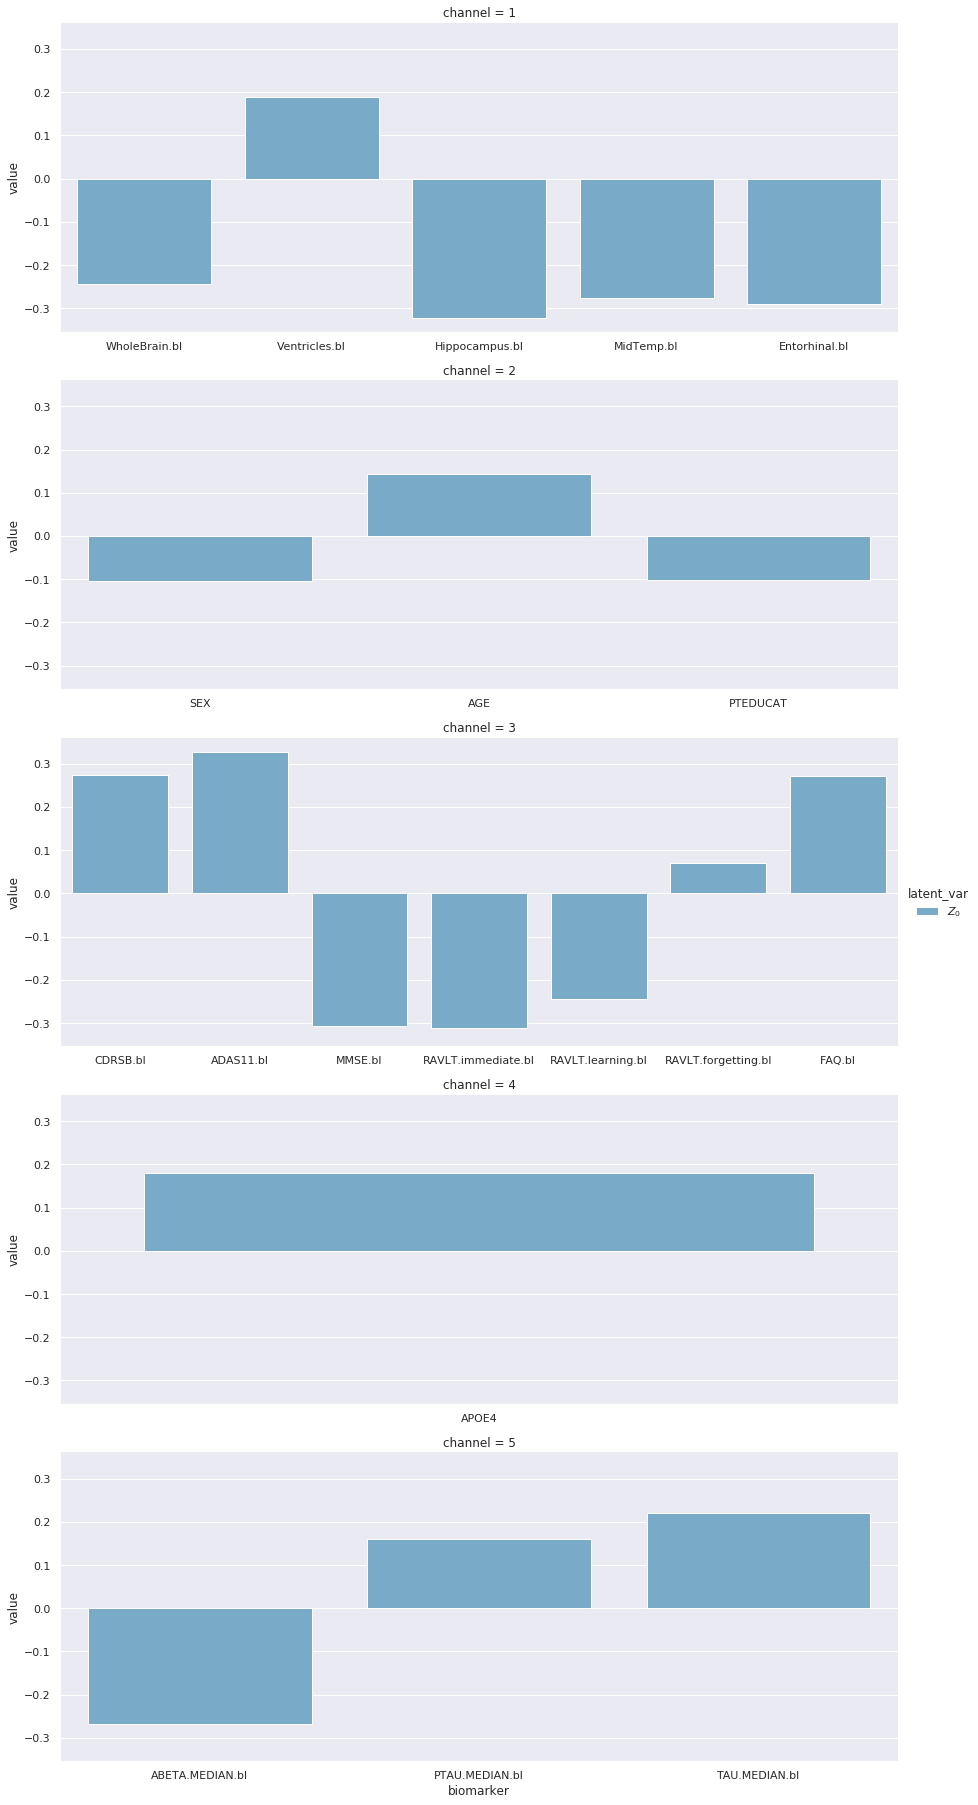

In [21]:
sns.catplot(data=weights_melt, x='biomarker', y='value', hue='latent_var', kind='bar', col='channel', col_wrap=1, aspect=2.5, sharex=False, palette='Blues_r')
plt.show()